In [1]:
%load_ext autoreload
%autoreload 2

## Fundamentals of Social Data Science
# Week 4. Day 1. Introducing classification 

Learning goals: 
- Understand TF-IDF as a means for getting document as well as term vectors. 
- Show how K-means and Naive Bayes work differently (as example inductive and deductive approaches to analysis)
- Show how TF-IDF scores work better for document classification than count scores. 
- Show how we can use a Multinomial case for Naive Bayes for multiple groups.
- Review the logic of classification (more in the lecture)

In order to run this lecture, you will need to update this GitHub repository as the code will partially draw from the existing functions within the library as well as make use of new ones. 

That said, we will also make use below of some self-contained examples. 

# How much of a difference is enough? 

If we look at any single corpus of text, we can use tools like TFIDF to characterise the top words as well as to represent the words in some 'word space'. When we examine the words in this word space we can measure how similar or different they are (within the space) using cosine similarity. We also showed that Euclidean distance is also sometimes useful, particularly as a measure of overall usage but not so useful at understanding difference between terms. These are examples of vector semantics. That is, we create a vector representing a term and then we use that vector to understand text relative to other text.

The prior walkthrough and lab may have obscured an important point, however. One can do vector semantics on a term or on a document since both can be vectors. In fact we can do semantics on entire corpora, but this can get dicey when the different corpus have substantially different sizes. 

Below, I will show how we can get cosine similarity scores for terms and for documents from the same corpus. Notice that all we need to do for the documents is to get the transpose of the TF-IDF matrix we already used. Indeed, it is effectively the same thing except now we have matrix that's as wide as the number of documents instead of a matrix that's as long as the number of documents. 

Before we get too deep in the code, I want to mention something that might have been held on faith up to this point. Why do projection of the TF-IDF matrix? As in, why not do a t-SNE just on the raw counts data? In some respects we can answer that inductively by showing the two and asserting that the t-SNE gives more information with TF-IDF. But today we will show a more grounded way to assert that (beyond the mathematical reasoning): TF-IDF scores will probably enable us to _classify_ documents more effectively. 

So once we show the document vectors and plot the documents rather than the terms in t-SNE, we will then move towards thinking about how to classify these documents. But that classification might be premised on a simpler question: if the documents are different, are they even different enough for us to distinguish them? How would we know? We can certainly do a decent job of distinguishing documents, but that comes with years of reading and some sense of context. But with just the text at hand, how do we know? 

To answer that is to go back to some of the basic forms of reasoning: inductive, abductive, and deductive. Abductive reasoning might also be called "practical" or pragmatic reasoning. It's normally reasoning from intuition or what might be the most likely story. It's a useful way to generate hypotheses that are then refined later. You would probably have used abductive reasoning to determine the choice of case for the first group exercise and maybe for the second one. However, if you have a clear theoretical framing and ways to strictly denote different classes (like 'treatment' and 'control') then you are applying deductive reasoning. And in the cases where we want to let the data speak for itself, we are employing inductive reasoning. But even then we probably use a little abductive reasoning to even consider which data to speak for itself.   

Below we will use a toy corpus I've generated with sentences about pets, cats, and technology. In all cases, we might see the use of the word 'game' or 'play' but otherwise these should be distinguishable sentences. So we can apply deductive reasoning to train a classifier by knowing which ones are supposed to be in which class. But we can also just see which sentences are nearest to each other. 

In the lab we will see this applied to different subreddits. With the tools on hand today, we will be able to:
- distinguish three subreddits from each other. 
- report on where there were misclassifications. 
- report on the documents or the terms that are either the most similar or distinct.
- appreciate the difference between an inductive and deductive approach to classification.

# Document and Term vectors: Considering Pets and Sports 

In the `example-data` folder are a couple `json` files. Feel free to have a look. The first one is a list of sentences concerning both pets and sports. The second one is a list of sentences concerning pets, sports, and technology. The files are not any specific standard, just a dictionary so we can keep some metadata about the files. Each row in the `documents` dictionary is a tuple with sentence and its category. Notice that we do not permit multiple categories here, meaning that each sentence will be termed as either 'pets', 'sports', 'tech'. 

The first file we will use below to show how we can create _term vectors_ and _document vectors_ from the same corpus and thereafter visualise them using t-SNE.

In [65]:
from utils.analysis import *
import json

def load_example_corpus(filename):
    """Load corpus from JSON file"""
    with open(filename, 'r') as f:
        return json.load(f)

# Load and analyze corpus
corpus = load_example_corpus("example-data/example-corpus_two_class.json")
corpus_text = [doc[0] for doc in corpus['documents']]
corpus_labels = [doc[1] for doc in corpus['documents']]

# Preprocess text
preprocessed_corpus = [preprocess_text(doc) for doc in corpus_text]


In [66]:
preprocessed_corpus

['cat dog play day',
 'cat love fish treat dog',
 'dog need daily walk stay healthy',
 'kitten sleep day cat active',
 'veterinarian help sick pet',
 'cat good pet',
 'cat friendly cat love cat play neighborhood cat cat food buy best cat food active cat',
 'team game',
 'athlete train every day preparation game',
 'coach call timeout athelete injure',
 'one player win team score three goal',
 'big game tomorrow everyone good health',
 'goalie good player',
 'football team play great game team show real teamwork team coach say team practice hard team deserve win important game',
 'game interrupt cat run onto field',
 'dog play game']

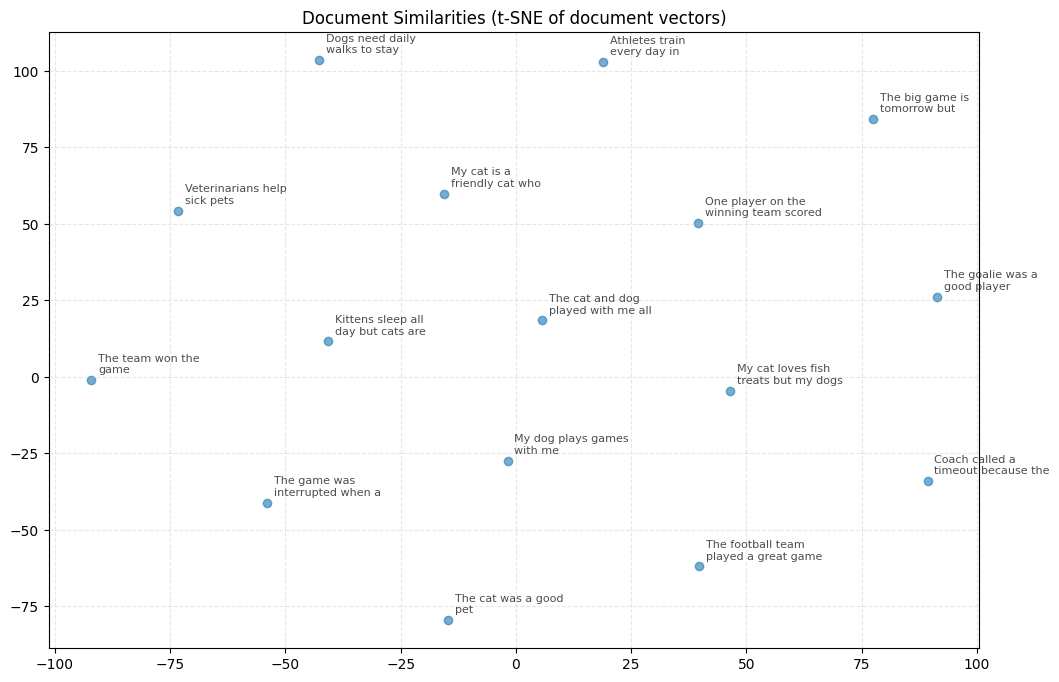

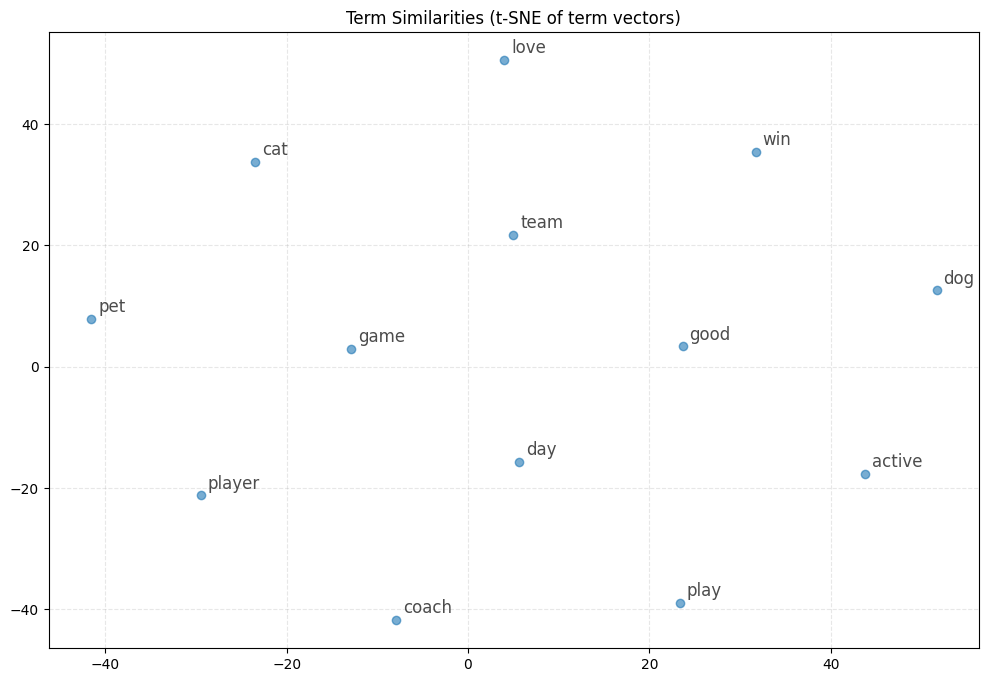

In [67]:
tfidf_matrix, terms = generate_tfidf_matrix(preprocessed_corpus)       

# Plot document similarities
fig_doc, ax_doc = plot_similarities(
    tfidf_matrix, 
    corpus_text,
    "Document Similarities (t-SNE of document vectors)"
)

# Plot term similarities
fig_term, ax_term = plot_similarities(
    tfidf_matrix, 
    terms,
    "Term Similarities (t-SNE of term vectors)", 
    is_documents=False
)

plt.show()

First let's explore what is happening differently in the code for the two cases. In the first case, we used `plot_similarities( tfidf_matrix, corpus['documents'])` and in the second we used `plot_similarities(tfidf_matrix, terms, is_documents=False`. When we look in the plot_similarities method we see that the second parameter is 'labels', which should correspond to what is plotted. If we pass `is_documents=False` the t-SNE takes the transpose of the matrix and then plots it so we see terms. Labels should therefore be the terms. If we pass `is_documents=True` then the t-SNE does everything the same except we don't transpose the document first, so our labels should refer to the documents. Now a long document might not be too clear and you could perhaps find another set of labels, but here I just passed the sentences which were used as labels. 

Now we know this corpus has labels and we already processed them. So let's plot this again, but use the labels instead of corpus text: 


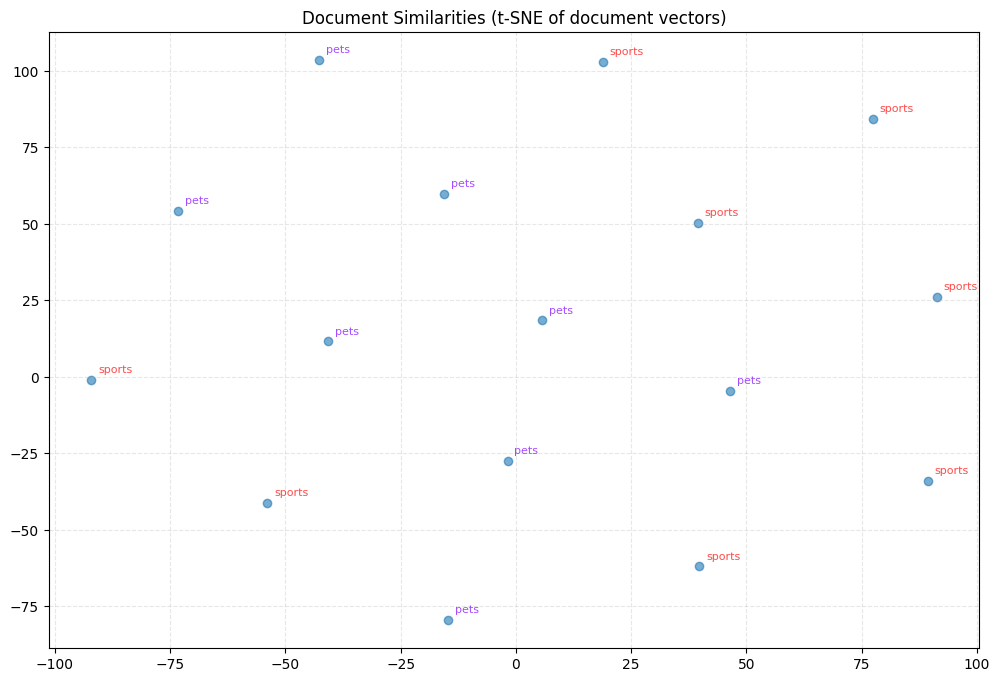

In [70]:
# Plot document similarities
fig_doc, ax_doc = plot_similarities(
    tfidf_matrix, 
    corpus_labels,
    label_color=True,
    title="Document Similarities (t-SNE of document vectors)",
    is_documents=True # This is the default, but we'll specify it here for clarity
)


So in this corpus we have two broad classes of topics: pets and sports. Both have sentences that mention play, game, and health. Notice that the t-SNE picks up on this in the arrangement of terms. However, it is not perfect and while it can arrange the terms pretty well, there appears to be some documents that are in the wrong 'region'. Notice these 'sports' documents in the lower left region of the screen. 

This is part of the 'curse of multidimensionality'. That is, we are trying to take many dimensions (one for each document or one for each term) and compress them into a two dimensional layout. We do this often because we want an intuition about the documents as a whole or about the terms and their associations. However, we do not need to visualise these documents in order to classify them. 

Below let's explore how we can classify these documents. Also we will do this on the raw counts as well as on the TF-IDF matrix. As it turns out, vectorizing doesn't mean 'make TF-IDF' and in fact there are a number of ways to vectorize a document. So below, notice that I use 'CountVectorizer' and 'TfIdfVectorizer' but otherwise I can keep things the same. 

# Inductive and Deductive classification 

Deductive reasoning is 'top down' and depends on prior information. It is closely related to the notion of supervised learning in machine learning. Deductive research questions are typically those informed by theory, whereas a deductive classification depends on 'ground truth', which is a term used for some means of labelling content according to a classification. 

These can be reconciled as we label content according to some theory about how it makes a difference and then go out and see whether that difference holds. In this case, we have a theory that sentences about pets and sentences about sports are semantically distinct. That is, if we have a sentence about pets we should be able to distinguish it from a sentence about sports. 

Inductive classification is about pattern matching. It is closely related to unsupervised learning in machine learning. Inductive research questions are often seen as descriptive or exploratory. We posit questions like 'can we identify distinct themes' (when doing the qualitative practice of grounded theory). Here were are looking for results that should allow us to meaningfully classify the documents. If we have ground truth then we can go back and look to whether our inductive classification does in fact capture the existing labelled structure. Maybe cats and sports aren't that different after all? 

There are many forms of classification, but there are some standard terms that we can use to assess the quality of a classification when we know the 'ground truth'. For these scores below, we can use the following terms: 
- TP = True Positives
- TN = True Negatives
- FP = False Positives
- FN = False Negatives

Now wouldn't a true positive be the same as a false negative? Not really. We do this from one label's perspective at a time. Imagine we are focused on pets. We will have some which are labelled pets, but in fact refer to sports (FP) whereas we will have some which are labelled sports but in fact pets (FN). We will also have some which are labelled pets, which are supposed to be pets (TP) and some labelled as sports which are correctly 'not-pets' (TN).  

So, now that we have these counts of which ones were labelled correctly, we can calculate some overall scores. 

- **Precision**: The proportion of true positive predictions among all positive predictions.
   * Formula: TP / (TP + FP)
   * Example: Of all documents we classified as "sports", what percentage were actually sports?
   * "When we predict positive, how often are we right?"

- **Recall**: The proportion of true positives identified among all actual positives.
   * Formula: TP / (TP + FN)
   * Example: Of all actual sports documents, what percentage did we correctly identify?
   * "Of all actual positives, how many did we catch?"

- **F1-score**: The _harmonic_ mean of precision and recall.
   * Formula: 2 * (Precision * Recall) / (Precision + Recall)
   * Balances precision and recall
   * Good when you need a single score and classes are imbalanced

- **Accuracy**: The proportion of correct predictions (both positive and negative) among all predictions.
   * Formula: (TP + TN) / (TP + TN + FP + FN)
   * Example: What percentage of all document classifications were correct?
   * Can be misleading with imbalanced classes

To remind us about the difference between F1 and accuracy consider that when developing these notes, I had a case where I had only 5 pet sentences and 11 about sports. The cheeky algorithm just labelled everything sports and got a high accuracy, but not a high F1 score.

Let's take a break from visualising and instead try to classify these documents. First we will use a deductive technique: Naive Bayes. 

# Naive Bayes Classification 

A naive bayes calculation looks to the odds of a word (or token) being in one class or the other class. A word that is overrepresented in one class of documents will then be used to calculate the odds that a new document is in one class or another. 

This means we have to set up our classification into a training set and a test set. We will use the training set to get our odds of a word showing up in a document and then apply it to the test set to see if that works. There's no fancy iteration or back propagation. It's just a simple (one might say naive) one shot 'count all the times this word showed up in one class vs. the rest'.  

Words like `game` and `health` will be in both classes so they should not be very informative. But a word like `team` or `cat` should be. 

- **Step 1**. Create the tokenized corpus and transform to the appropriate shape for analysis (try with and without stop words).
- **Step 2**. Get the results of the analysis.
- **Step 3**. Use the ground truth labels to check how accurate our classification is (i.e. how well do the words help us predict the class)?

In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Create TF-IDF matrix
vectorizer = TfidfVectorizer(min_df=2)
# vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)

# Split data for NBC
X_train, X_test, y_train, y_test = train_test_split(
    X, corpus_labels, test_size=0.3, random_state=42
)

print(X_train.shape, X_test.shape) 
# print(X_train.toarray())
print(len(y_train), y_train)
print(len(y_test), y_test)

(11, 26) (5, 26)
11 ['sports', 'sports', 'sports', 'pets', 'pets', 'pets', 'sports', 'sports', 'sports', 'pets', 'pets']
5 ['pets', 'pets', 'pets', 'sports', 'sports']


In [73]:
# Naive Bayes Classification
nbc = MultinomialNB()
nbc.fit(X_train, y_train)
nbc_pred = nbc.predict(X_test)

# Analyze results
print("Naive Bayes Classification Results:")
print(classification_report(y_test, nbc_pred))

Naive Bayes Classification Results:
              precision    recall  f1-score   support

        pets       1.00      0.67      0.80         3
      sports       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



To summarise the results, it seems that every one of the docs labelled pets were in fact pets, but that we missed one of the pets documents, hence our recall is only 0.67. 

Admittedly this is not going to be very informative with only 16 documents and 26 unique word tokens. With 30% test data we trained on 11 docs and only tested on only 5. Nonetheless, it was able to get some good accuracy. In the lab, you will see this is probably going to be more informative in the case of subreddit headlines since you might have several hundred headlines. But it might not be any more accurate depending on the subreddits and their overlap. 

Now to return to the question of whether TF-IDF scores are better than raw counts, it turns out we can vectorize our documents with a CountVectorizer to compare. When we do that, will our scores be better? In general the scores should be better with TF-IDF and the difference will be increasingly noticeable with more documents of longer and more varied sizes since TF-IDF is ultimately just a way to weight the words by considering their distribution in all the documents. 

In [74]:
# Create TF-IDF matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)

# Split data for NBC
X_train, X_test, y_train, y_test = train_test_split(
    X, corpus_labels, test_size=0.3, random_state=42
)

# Naive Bayes Classification
nbc = MultinomialNB()
nbc.fit(X_train, y_train)
nbc_pred = nbc.predict(X_test)

# Analyze results
print("Naive Bayes Classification Results:")
print(classification_report(y_test, nbc_pred))

Naive Bayes Classification Results:
              precision    recall  f1-score   support

        pets       1.00      0.67      0.80         3
      sports       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In this case, it seems it did not make much of a difference. This is owning to the simplicity of the text and the fact that most terms don't really show up more than a couple times and rarely in the same document. However, in your own work and with larger documents will will likely see considerably higher accuracy for TF-IDF. 

Speaking of the lab, up until this point I have encouraged you to look at a single subreddit per plot in the lab. But as this approach shows, we can combine documents and look at the tf-idf scores of the combined corpus. To note, we did not create a separate matrix for pets and one for sports and then somehow merge them. We created a single matrix for all of them.  

But what if we have three classes? This particular approach already handles that. It is called a 'Multinomial Naive Bayes' and predicts to as many classes as we have labels. With small data it will be hard to do a nice clear example, but we can at least go through the steps with a second json file. This one with 8 more sentences, this time about technology. Again, we will see the use of the words 'game' and 'health', but we will talk about battery health and playing video games. So let's see if we can suitably classify all of the statements. 

In [75]:
# Load and analyze corpus
corpus = load_example_corpus("example-data/example-corpus_three_class.json")
corpus_text = [doc[0] for doc in corpus['documents']]
corpus_labels = [doc[1] for doc in corpus['documents']]

# Preprocess text
preprocessed_corpus = [preprocess_text(doc) for doc in corpus_text]

vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)

# Split data for NBC
X_train, X_test, y_train, y_test = train_test_split(
    X, corpus_labels, test_size=0.3, random_state=42
)

# Naive Bayes Classification
nbc = MultinomialNB()
nbc.fit(X_train, y_train)
nbc_pred = nbc.predict(X_test)

# Analyze results
print("Naive Bayes Classification Results:")
print(classification_report(y_test, nbc_pred))

Naive Bayes Classification Results:
              precision    recall  f1-score   support

        pets       0.50      1.00      0.67         2
      sports       1.00      0.50      0.67         4
        tech       1.00      1.00      1.00         2

    accuracy                           0.75         8
   macro avg       0.83      0.83      0.78         8
weighted avg       0.88      0.75      0.75         8



Once again we can see the precision and recall scores per class as well as averages per class and an overall accuracy score. We can also report on the most informative words to help distinguish the separate classes as well: 

In [76]:
# Report most informative features
def most_informative_features(vectorizer, classifier, n=10):
    feature_names = vectorizer.get_feature_names_out()
    class_labels = classifier.classes_
    top_features = {}

    for i, class_label in enumerate(class_labels):
        top_indices = classifier.feature_log_prob_[i].argsort()[-n:][::-1]
        top_features[class_label] = [(feature_names[j], classifier.feature_log_prob_[i][j]) for j in top_indices]

    return top_features

top_features = most_informative_features(vectorizer, nbc, n=5)
print("\nTop Features per Class:")
for class_label, features in top_features.items():
    print(f"\nClass: {class_label}")
    for feature, log_prob in features:
        print(f"  {feature}: {np.exp(log_prob):.4f}")


Top Features per Class:

Class: pets
  cat: 0.0843
  cats: 0.0814
  dogs: 0.0727
  plays: 0.0699
  active: 0.0658

Class: sports
  player: 0.0968
  team: 0.0963
  game: 0.0883
  cat: 0.0683
  good: 0.0652

Class: tech
  software: 0.1446
  coding: 0.1040
  code: 0.0839
  game: 0.0678
  advanced: 0.0580


# Inductive classification: K-means as example

What if we do not know which documents belong to sports, pets, or tech? In this case if we have a hunch that there are three separate classes we can use a technique called k-means. Imagine the t-SNE map to be a representation of some space where we see all the words or the documents. In that space we can calculate the distance from one point to another point (as we have done with cosine distance). So let's say we propose there are two groups (i.e. k=2). To use k-means we place two 'centroids' on the map and then move them around so that on average the points on the map have the shortest distance to one of the centroids. So in the end we have a solution where clusters seem to be associated with those that are on average the most similar. 

K-means is a simple inductive classification approach. One notable aspect of it (and arguably a drawback) is that you have to select K. So in our examples with pets, sports, and tech, we knew there would be 3 groups. However, in the case where we do not have prior knowledge, the number of groups is a tricky matter. You may explore in later work about how to set K. 

In the Week 4 Day 2 lecture we will see how in network analysis there is an inductive test called "community detection" which can partition a network into pretty intelligible subgroups without being told exactly how many. Those tests tend to work because of the advantages (or perhaps limits) of network data structures.

Below is a visual demonstration of k-means. The algorithm is black boxed here, but it is generally intelligible if you look it up either through sklearn's source code or elsewhere online. Notice the use of `make_blobs`. These are random gausian distributions that are used for demonstration purposes. Here we make four blobs and then use k-means to label the blobs. It is generally accurate but that's because this is synthetic data made for this purpose. 

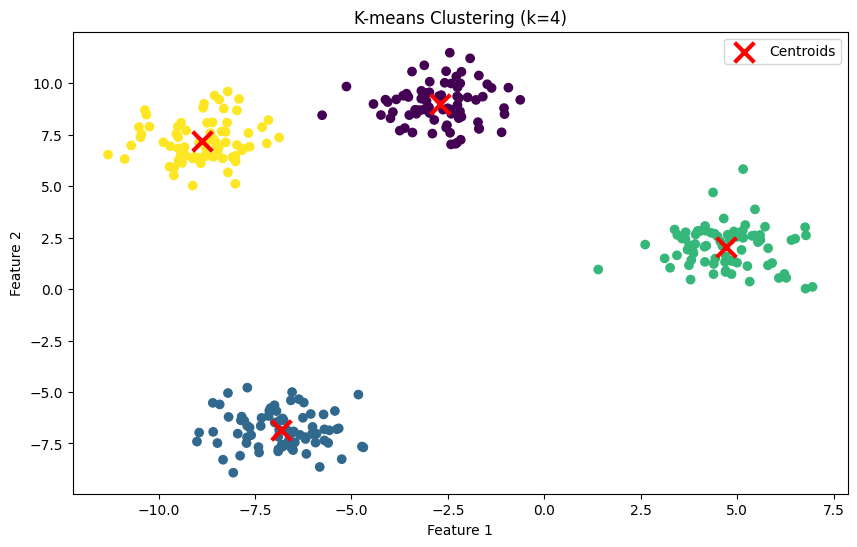


Cluster Centers:
Cluster 0: [-2.70981136  8.97143336]
Cluster 1: [-6.83235205 -6.83045748]
Cluster 2: [4.7182049  2.04179676]
Cluster 3: [-8.87357218  7.17458342]

Inertia: 564.91


In [77]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Generate sample data
np.random.seed(42)
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)

# Create and fit the k-means model
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the data points, colored by their cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis')

# Plot the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], 
           kmeans.cluster_centers_[:, 1], 
           c='red', 
           marker='x', 
           s=200, 
           linewidth=3, 
           label='Centroids')

plt.title('K-means Clustering (k=4)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Print the cluster centers
print("\nCluster Centers:")
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"Cluster {i}: {center}")

# Print inertia (sum of squared distances to closest centroid)
print(f"\nInertia: {kmeans.inertia_:.2f}")

Above we see the centroids marked with X. These are used to calculate the inertia score. It is one of several scores to check the goodness of fit such as  Silhouette and Calinski-Harabasz. This one is simply a calculation of distance to the centroid. So below lets look at this score in two scenarios: a spread out (as in less distinct set of blobs) * the assumed number of blobs or an incorrect number of blobs. 

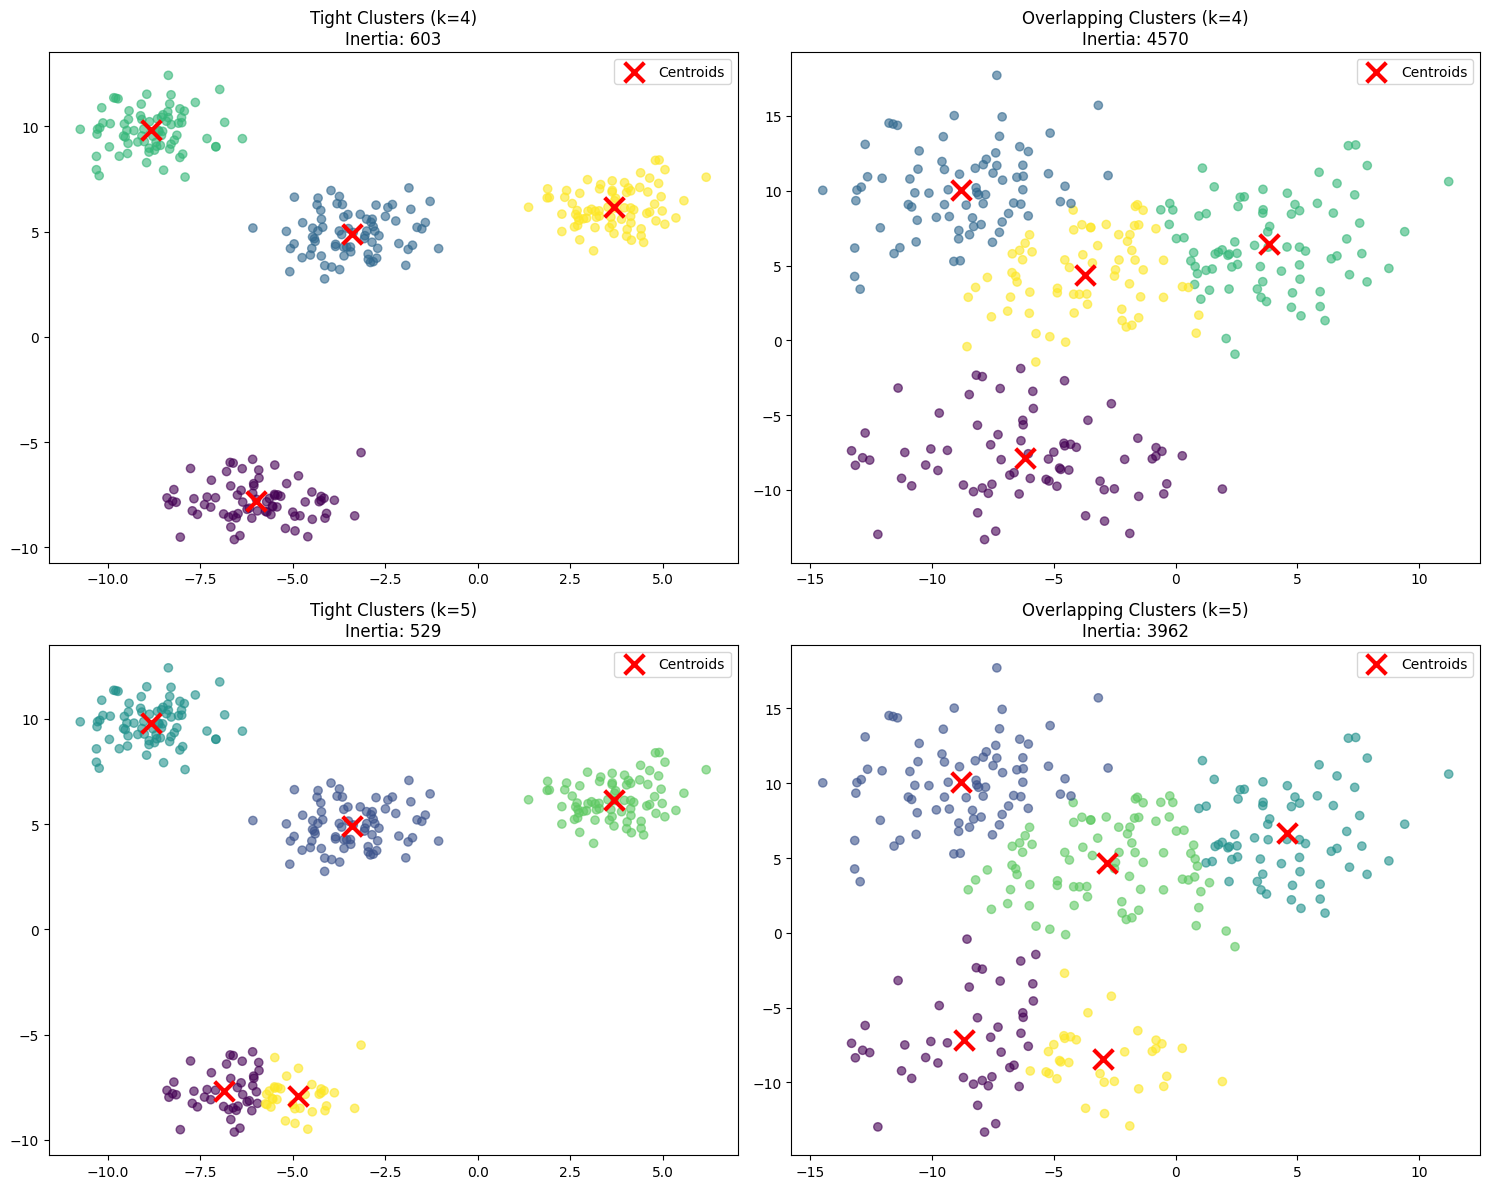


Tight Clusters (k=4)
Inertia: 603

Overlapping Clusters (k=4)
Inertia: 4570

Tight Clusters (k=5)
Inertia: 529

Overlapping Clusters (k=5)
Inertia: 3962


In [58]:
# Set up the figure
plt.figure(figsize=(15, 12))

# Generate two datasets - one with tight clusters, one with overlapping
n_samples = 300
random_state = 421

# Dataset 1: Tight clusters
X1, y1 = make_blobs(n_samples=n_samples, 
                    centers=4,
                    cluster_std=1.0,
                    random_state=random_state)

# Dataset 2: More spread out clusters (same centers)
X2, y2 = make_blobs(n_samples=n_samples, 
                    centers=4,
                    cluster_std=3,  # Increased standard deviation
                    random_state=random_state)

# Plot configurations
configs = [
    (X1, 4, 221, "Tight Clusters (k=4)"),
    (X2, 4, 222, "Overlapping Clusters (k=4)"),
    (X1, 5, 223, "Tight Clusters (k=5)"),
    (X2, 5, 224, "Overlapping Clusters (k=5)")
]

for X, k, plot_num, title in configs:
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    cluster_labels = kmeans.fit_predict(X)
    
    # Create subplot
    plt.subplot(plot_num)
    
    # Plot the data points, colored by their cluster assignments
    plt.scatter(X[:, 0], X[:, 1], 
               c=cluster_labels, 
               cmap='viridis',
               alpha=0.6)
    
    # Plot the cluster centers
    plt.scatter(kmeans.cluster_centers_[:, 0],
               kmeans.cluster_centers_[:, 1],
               c='red',
               marker='x',
               s=200,
               linewidth=3,
               label='Centroids')
    
    plt.title(f"{title}\nInertia: {kmeans.inertia_:.0f}")
    plt.legend()

plt.tight_layout()
plt.show()

# Print inertia values for comparison
for X, k, _, title in configs:
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(X)
    print(f"\n{title}")
    print(f"Inertia: {kmeans.inertia_:.0f}")

In the case where our blobs were spread out, the 5-solution seemed pretty plausible even though it's not really the case that those are separate clusters. In both cases the inertia went down with more k (since there is now more centroids to be closer to). But even if inertia went down we know that the number of groups was really four, so we would need to do a little more exploring at least (including the exploration of other metrics like CH which account for distance within and between).  

If we know the labels ahead of time, we can use k-means as a form of classification. However, we will do this slightly differently than before. With Naive Bayes we would get a classification report (i.e. look at precision and recall) by using test data that is separate from the training data. We started off knowing that group 1 was pets, and we just wanted to predict the odds that a word would be better represented among pets. 

Yet with k-means we just have three centroids, we don't have a centroid called 'pets'. The three centroids could all start close to pets and then settle towards the three groups. So below is a little bit of tricky code to determine which group is mostly which label. For us, it is easy to do this as we can look at a plot, see that the blue points mean are mostly on the 'pet' sentences and the red points mean 'sports'. But in this case, the algorithm determines what is the majority label for that group and then uses that to check the classification scores. 

In [78]:
# Load and analyze corpus
corpus = load_example_corpus("example-data/example-corpus_three_class.json")
corpus_text = [doc[0] for doc in corpus['documents']]
corpus_labels = [doc[1] for doc in corpus['documents']]

# Preprocess text
preprocessed_corpus = [preprocess_text(doc) for doc in corpus_text]

vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
X = vectorizer.fit_transform(corpus_text)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# For k-means, we need to map cluster numbers to labels
# Find most common true label in each cluster
cluster_label_counts = {}
for cluster_label, true_label in zip(kmeans_labels, corpus_labels):
    if cluster_label not in cluster_label_counts:
        cluster_label_counts[cluster_label] = {}
    if true_label not in cluster_label_counts[cluster_label]:
        cluster_label_counts[cluster_label][true_label] = 0
    cluster_label_counts[cluster_label][true_label] += 1

# Map clusters to majority labels
cluster_to_label = {
    cluster: max(counts.items(), key=lambda x: x[1])[0]
    for cluster, counts in cluster_label_counts.items()
}

# Convert cluster numbers to predicted labels
kmeans_pred = [cluster_to_label[label] for label in kmeans_labels]

print("\nK-means Clustering Results:")
print(classification_report(corpus_labels, kmeans_pred))


K-means Clustering Results:
              precision    recall  f1-score   support

        pets       1.00      0.50      0.67         8
      sports       0.62      1.00      0.76         8
        tech       1.00      0.88      0.93         8

    accuracy                           0.79        24
   macro avg       0.87      0.79      0.79        24
weighted avg       0.87      0.79      0.79        24



# Today's Lab 

Now equipped with some vector operations for being able to plot documents as well as terms, classify documents, and to check the distance of both terms and documents, you can get pretty far along with determining which documents (and by implication) which subreddits are closest together. 

This is not an exercise where there is usually a necessary right answer. In the lab we will see more guided questions to help explore this. 


# Where we are headed with this 

In the Week 4 Day 2 lecture we will look at network structures. A network exists when we can identify a link or relation between two nodes. While text can be metaphorically thought of as a network, we might find more direct sources of network data such as threaded conversations and user accounts. We will see how to create and visualise a network of comments and of users. We will show an inductive technique called community detection and a new approach to similarity: bipartite projection. It has some real commonalities with TF-IDF but in some ways is more simple. 

Then on the last day of class it seems unfair to show another similarity metric when we have presentations on these subreddits on Friday. So instead of another metric, we will show another way to Vectorize. But here is the twist: our vectors will not come from the counts of the words in documents. They will come from complex 'models' of text. These are document embeddings and they are the way we can encode documents by taking into account not just the text in a document or even a small corpus, but the learned representation of text in a very large existing model. This will be for demonstration only as I will not assume everyone has access to Brains, and running these models can be a tad slow on laptop computers. We will also briefly discuss the summative. 